In [66]:
import pandas as pd
import re
from pygeocoder import Geocoder
from scipy import stats
import pylab

In [67]:
user_df = pd.read_csv("user_table.csv")
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [68]:
test_df = pd.read_csv("test_results.csv")
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [69]:
df = test_df.merge(user_df, how='left', on='user_id')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [70]:
df['timestamp'] = df['timestamp'].apply(lambda x: re.sub('60', '00', x)) 
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [71]:
df['date'] = df['timestamp'].dt.date

In [75]:
data_test = df[df['test']==1]
data_control = df[df['test']==0]

/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


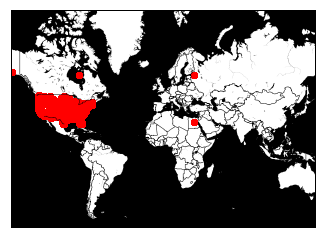

In [48]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import string
import matplotlib.cm as cm
#m = Basemap(projection='ortho',lon_0=-50,lat_0=60,resolution='l')
m = Basemap(llcrnrlon=-150.,llcrnrlat=-60.,urcrnrlon=150.,urcrnrlat=80.,\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=20.,lon_0=-20.,lat_ts=20.)
x1,y1=m(df['long'].values,df['lat'].values)
m.drawmapboundary(fill_color='black') # fill to edge
m.drawcountries()
m.fillcontinents(color='white',lake_color='black',zorder=0)
m.scatter(x1,y1,marker="o",c='red',cmap=cm.cool,alpha=0.7)
plt.title("")
plt.show()

In [21]:
import time
for i in range(df.shape[0]):
    time.sleep(5)
    results = Geocoder.reverse_geocode(df['lat'][0], df['long'][0])
    if(results.country == 'United States'):
        results.country = "USA"
    if(results.country != df['country'][0]):
        print("{} {}".format(results.country,df['country'][0]))
        results.city

United States USA
United States USA
United States USA
United States USA
United States USA
United States USA


GeocoderError: Error OVER_QUERY_LIMIT
Query: https://maps.google.com/maps/api/geocode/json?latlng=42.890000%2C-78.860000&sensor=false&bounds=&region=&language=

In [50]:
data_test = df[df['test']==1]
data_control = df[df['test']==0]

In [53]:
stats.ttest_ind(data_test['converted'], data_control['converted'])
print(data_test['converted'].mean())
print(data_control['converted'].mean())

0.0155426788109
0.0199036142201


In [76]:
df['control'] = df['test'].apply(lambda x: 1 if x==0 else 0 )
df1 = data_test[['converted','date']]
mean = df1.groupby('date').mean()

df2 = data_control[['converted','date']]
mean1 = df2.groupby('date').mean()
 
fg = plt.figure(figsize=(15, 8))
pylab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pylab.plot(mean1['converted'],'-', label="control")#control

pylab.plot(mean['converted'],'-', label="test")
pylab.legend(loc='center left', bbox_to_anchor=(1, 0.5))#test

/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


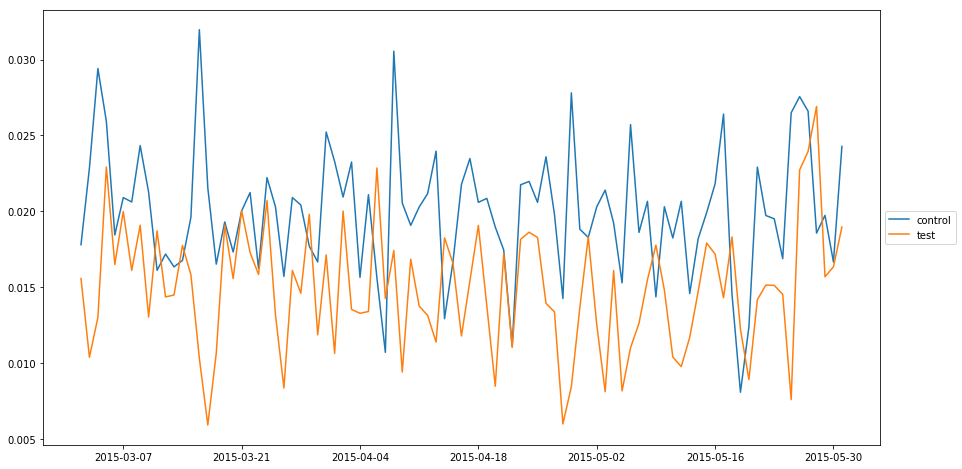

In [77]:
plt.show()

In [83]:
data_test_nona = data_test.dropna()
data_control_nona = data_control.dropna()
city_list = data_test_nona['city'].unique()
output = []
nconverts_test = []
nconverts_control = []
n_test = []
n_control = []
stat = []

for city in city_list:
    data_test_nona_bycity = data_test_nona[data_test_nona['city']==city]
    data_control_nona_bycity = data_control_nona[data_control_nona['city']==city]
    output.append(stats.ttest_ind(data_test_nona_bycity['converted'], data_control_nona_bycity['converted']).pvalue)
    nconverts_test.append(data_test_nona_bycity['converted'].mean())
    nconverts_control.append(data_control_nona_bycity['converted'].mean())
    n_test.append(len(data_test_nona_bycity))
    n_control.append(len(data_control_nona_bycity))
    stat.append(stats.ttest_ind(data_test_nona_bycity['converted'], data_control_nona_bycity['converted']).statistic)
    
final_df = pd.DataFrame({'City':city_list, 'P_Value':output, 'test_statistic':stat,'nconverts_test':nconverts_test,'nconverts_control':nconverts_control
                             ,'n_test':n_test,'n_control':n_control})

output = final_df.sort_values(by='P_Value', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last').reset_index(drop=True).head(26)

/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3146: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/rebecca/anaconda3/envs/my_projects_env/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [84]:
output.head()

,City,P_Value,n_control,n_test,nconverts_control,nconverts_test,test_statistic
0,Chapel Hill,0.003946,39,5,0.000000,0.200000,3.050708
1,Lincoln,0.009189,377,228,0.029178,0.000000,-2.613390
2,Lehigh Acres,0.011892,27,19,0.000000,0.210526,2.624301
3,Southaven,0.012769,104,17,0.000000,0.058824,2.528352
4,Temecula,0.013011,112,48,0.008929,0.083333,2.511952
